## JPL Demo Notebook
This notebook demonstrates the functionality of JPL. We show how to load the model and perform detection on a single example image. We also show some example images from minidepth.

### Basic Setup

Import packages, set device and define utility functions

In [1]:
import cv2
import flow_vis
from matplotlib import pyplot as plt
import numpy as np
import torch
from pathlib import Path
from gluefactory.models import get_model
from gluefactory.visualization.viz2d import plot_images, plot_lines

In [2]:
# We want larger figures
plt.rcParams["figure.figsize"] = (7,7)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
def get_flow_vis(df, ang, line_neighborhood=5):
    """Visualize flow of angle field"""
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions.
    Used when loading single Images, not from a glue-factory dataset"""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

def load_image_from_path(path: str, resize=None, plot_image=False):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, resize)
    if plot_image:
        plt.imshow(img)
    img_torch = numpy_image_to_torch(img).to(device)
    img_torch = img_torch.unsqueeze(0)
    return img_torch

Import and visualize demo picture

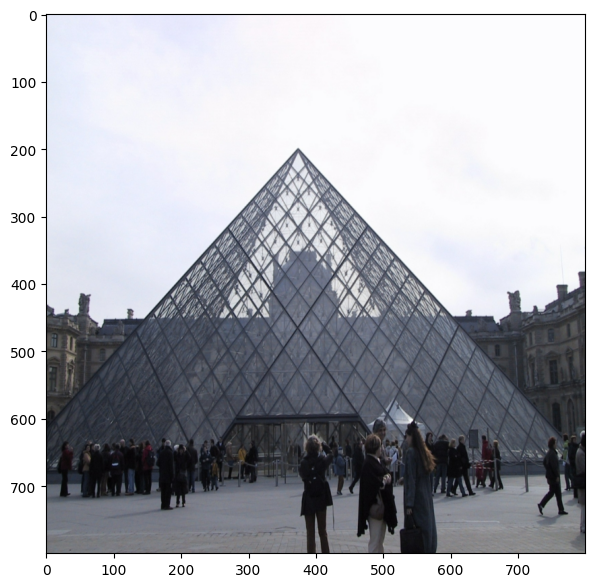

In [5]:
size = (800,800)
image_path = f"demo_louvre.jpg"
torch_image = load_image_from_path(image_path, resize=size, plot_image=True)

### Load the Model

Here we give no configuration. The weights are downloaded automatically and should agree with the default conf. Also, the line_detection is activated by default.

Currently the loaded model is oxparis-800-focal. The line detection is heuristic filtering based on the line-distance field

In [6]:
jpl_conf = {
    "max_num_keypoints": -1,  # setting for training, for eval: -1
    "detection_threshold": 0.15,
    "timeit": True,  # model collects timing statistics internally during forward passes
    "line_detection": {
        "do": True,
        "conf": {
            "max_point_size": 1500,
            "nms": True,
            "distance_map": {
                "max_accepted_mean_value": 0.4,
            },
            "brute_force_df": {
                "use": True,
                "inlier_ratio": 0.95,                # Ratio of inliers
                "max_accepted_mean_value": None,  #0.4     # Maximum accepted DF mean value along the line
                "binary_threshold": 0.5,            # Threshold for binarizing the distance field
            },
        },
    },
    "checkpoint": "/home/pautratrmi/Documents/experiments/JPL/oxparis_800_focal/checkpoint_best.tar"
}

# load the default model
jpldd_model = get_model("joint_point_line_extractor")(jpl_conf).to(device)
jpldd_model.eval()

/home/pautratrmi/Documents/external/JPL/glue-factory/gluefactory/models/extractors/joint_point_line_extractor.py:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt_sta

JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [7]:
# Load DeepLSD model and fast DeepLSD
deeplsd_conf = {
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "grad_nfa": False,
            "filtering": "strict",
            "faster_lsd": False,
        }
    }
}
deeplsd_model = get_model("deeplsd")(deeplsd_conf).to(device)
deeplsd_model.eval()

deeplsd_fast_conf = {
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "grad_nfa": False,
            "filtering": "strict",
            "faster_lsd": True,
        }
    }
}
deeplsd_fast_model = get_model("deeplsd")(deeplsd_fast_conf).to(device)
deeplsd_fast_model.eval()

# Load original pytlsd and fast_pytlsd
pytlsd_conf = {
    "model_conf": {
        "faster_lsd": False,
    }
}
pytlsd_model = get_model("lsd")(pytlsd_conf).to(device).eval()

pytlsd_fast_conf = {
    "faster_lsd": True,
}
pytlsd_fast_model = get_model("lsd")(pytlsd_fast_conf).to(device).eval()

module 'deeplsd' has no attribute '__main_model__'
module 'deeplsd' has no attribute '__main_model__'


/home/pautratrmi/Documents/external/JPL/glue-factory/gluefactory/models/lines/deeplsd.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt, map_locati

In [8]:
# run fw pass with one image
with torch.no_grad():
    output_jpldd = jpldd_model({"image": torch_image})
    output_deeplsd = deeplsd_model({"image": torch_image})
    output_deeplsd_fast = deeplsd_fast_model({"image": torch_image})
    output_pytlsd = pytlsd_model({"image": torch_image})
    output_pytlsd_fast = pytlsd_fast_model({"image": torch_image})

print(f"JPLDD {len(output_jpldd['lines'][0])} lines detected")
print(f"DeepLSD {len(output_deeplsd['lines'][0])} lines detected")
print(f"Fast DeepLSD {len(output_deeplsd_fast['lines'][0])} lines detected")
print(f"LSD {len(output_pytlsd['lines'][0])} lines detected")
print(f"Fast LSD {len(output_pytlsd_fast['lines'][0])} lines detected")

# print("-- Output Keys --")
# for i, key in enumerate(output_jpldd.keys()):
#     output_jpldd[key] = output_jpldd[key].cpu()
#     print(f"{i}: {key}, shape: {output_jpldd[key][0].shape}")

Time elapsed: 0.0159865 seconds
Time elapsed: 0.0186409 seconds
JPLDD 320 lines detected
DeepLSD 754 lines detected
Fast DeepLSD 755 lines detected
LSD 712 lines detected
Fast LSD 838 lines detected


/home/pautratrmi/Documents/external/JPL/glue-factory/gluefactory/models/lines/lsd.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  lines = torch.tensor(lines, dtype=torch.float, device=device)


### Visualize results

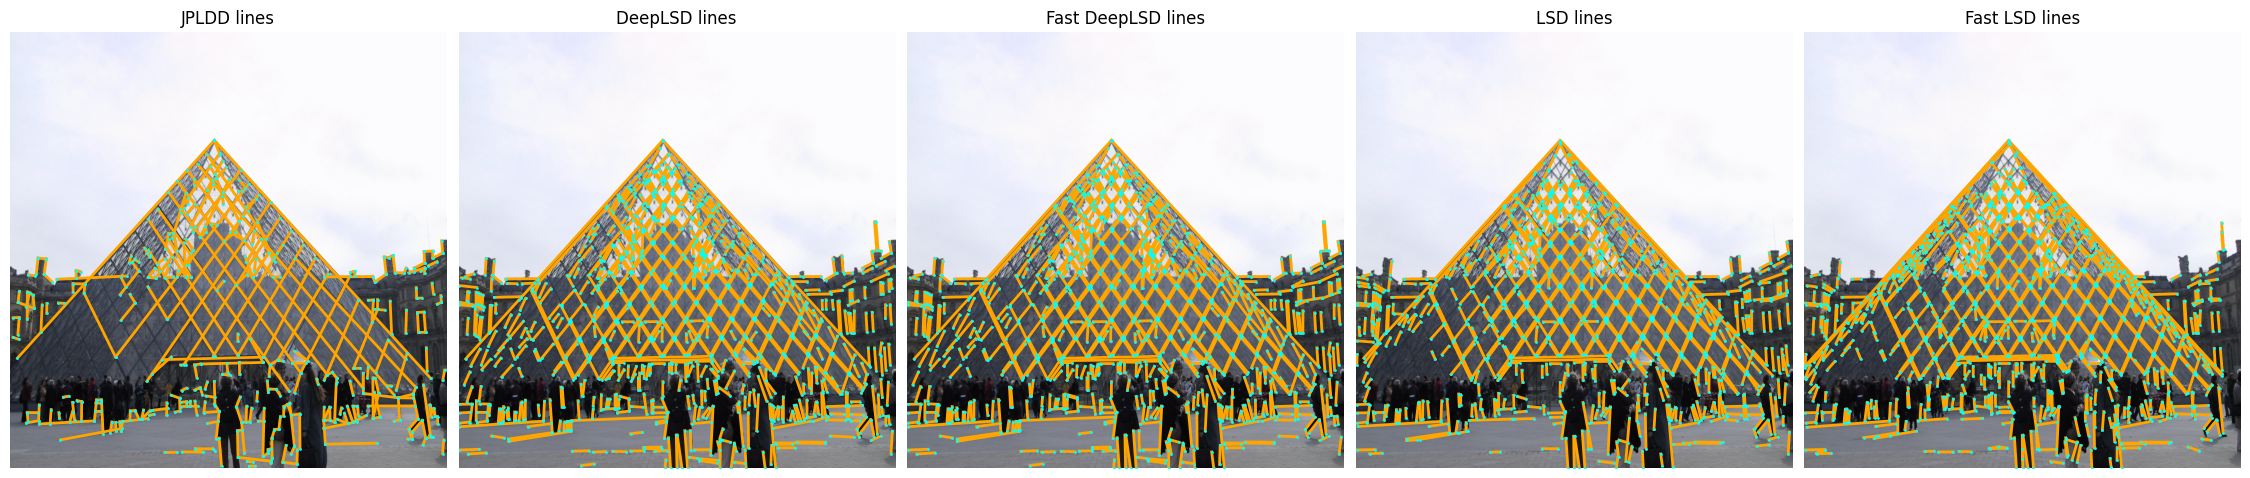

In [9]:
img = torch_image.cpu().squeeze(0).permute(1,2,0)
plot_images([img] * 5, ["JPLDD lines", "DeepLSD lines", "Fast DeepLSD lines", "LSD lines", "Fast LSD lines"])
plot_lines([
    output_jpldd["lines"][0].cpu().numpy(),
    output_deeplsd["lines"][0].cpu().numpy(),
    output_deeplsd_fast["lines"][0].cpu().numpy(),
    output_pytlsd["lines"][0].cpu().numpy(),
    output_pytlsd_fast["lines"][0].cpu().numpy()], indices=range(5))